# Detect Malicious URLs using Maching Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv('../../URLs/malicious_phish.csv')

In [4]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
df.shape

(651191, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [7]:
df.isna().sum()

url     0
type    0
dtype: int64

In [8]:
le= LabelEncoder()
le.fit(df["type"])

df["labels"] = le.transform(df["type"])

In [9]:
df.head()

,url,type,labels
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [10]:
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_label_mapping

{'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}

In [11]:
df = df.drop("type", axis=1)
df.head()

,url,labels
0,br-icloud.com.br,3
1,mp3raid.com/music/krizz_kaliko.html,0
2,bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,1
4,http://adventure-nicaragua.net/index.php?optio...,1


## Feature Extraction

### Check IP

In [12]:
import re

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    return 1 if match else 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [13]:
df

,url,labels,use_of_ip
0,br-icloud.com.br,3,0
1,mp3raid.com/music/krizz_kaliko.html,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0
4,http://adventure-nicaragua.net/index.php?optio...,1,0
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0


### Abnormal URL

In [14]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    
    return 1 if match else 0

In [15]:
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
df

,url,labels,use_of_ip,abnormal_url
0,br-icloud.com.br,3,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1
...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0


### Count of dot (.)

In [16]:
df['count.'] = df['url'].apply(lambda i: i.count('.'))
df.head()

,url,labels,use_of_ip,abnormal_url,count.
0,br-icloud.com.br,3,0,0,2
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2


### Count of (www)

In [17]:
df['count-www'] = df['url'].apply(lambda i: i.count('www'))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www
0,br-icloud.com.br,3,0,0,2,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0
...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0


### Count of  (@)

In [18]:
df['count@'] = df['url'].apply(lambda i: i.count('@'))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@
0,br-icloud.com.br,3,0,0,2,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0
...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0


### Count URL Depth

In [19]:
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir
0,br-icloud.com.br,3,0,0,2,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1
...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2


### Count of Embedded URL

In [20]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian
0,br-icloud.com.br,3,0,0,2,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0


### Count of Suspicious Words

In [21]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    return 1 if match else 0

df['sus_words'] = df['url'].apply(lambda i: suspicious_words(i))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0


### Count Shortening URL

In [22]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    return 1 if match else 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0


### Count HTTP

In [23]:
df['count-http'] = df['url'].apply(lambda i: i.count('http:'))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,count-http
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0,0


### Count HTTPS

In [24]:
df['count-https'] = df['url'].apply(lambda i: i.count('https'))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,count-http,count-https
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0,0,0


### Count (%)

In [25]:
df['count%'] = df['url'].apply(lambda i: i.count('%'))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,count-http,count-https,count%
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0,0,0,0


### Count (-)

In [26]:
df['count-'] = df['url'].apply(lambda i: i.count('-'))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,count-http,count-https,count%,count-
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0,0,0,0,1
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0,1,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1,0,0,0,2
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0,0,0,0,0


### Count (=)

In [27]:
df['count='] = df['url'].apply(lambda i: i.count('='))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,count-http,count-https,count%,count-,count=
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0,0,0,0,1,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0,1,0,0,1,4
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0,1,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0,0,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1,0,0,0,2,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0,0,0,0,0,0


### Digit Count

In [28]:
def count_digit(url):
    return sum(c.isdigit() for c in url)

df['count-digits'] = df['url'].apply(lambda i: count_digit(i))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,count-http,count-https,count%,count-,count=,count-digits
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0,0,0,0,0,0,1
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0,1,0,0,1,4,7
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0,1,0,0,1,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0,0,0,0,0,0,12
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1,0,0,0,2,0,7
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1,0,0,0,0,0,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0


### Letter Count

In [29]:
def count_letter(url):
    return sum(c.isalpha() for c in url)

df['count-letters'] = df['url'].apply(lambda i: count_letter(i))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,count-http,count-https,count%,count-,count=,count-digits,count-letters
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0,0,0,0,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0,1,0,0,1,4,7,63
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0,1,0,0,1,3,22,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0,0,0,0,0,0,12,21
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1,0,0,0,2,0,7,29
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1,0,0,0,0,0,3,33
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,36


### URL Length

In [30]:
df['url_length'] = df['url'].apply(lambda i: len(str(i)))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,count-http,count-https,count%,count-,count=,count-digits,count-letters,url_length
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,13,16
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,1,29,35
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0,0,0,0,0,0,1,25,31
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0,1,0,0,1,4,7,63,88
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0,1,0,0,1,3,22,199,235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0,0,0,0,0,0,12,21,39
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1,0,0,0,2,0,7,29,44
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1,0,0,0,0,0,3,33,42
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,36,45


### Hostname Length

In [31]:
df['hostname_length'] = df['url'].apply(lambda i: len(urlparse(i).netloc))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,count-http,count-https,count%,count-,count=,count-digits,count-letters,url_length,hostname_length
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,13,16,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,1,29,35,0
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,0,0,0,0,0,0,1,25,31,0
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,0,1,0,0,1,4,7,63,88,21
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,0,1,0,0,1,3,22,199,235,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,0,0,0,0,0,0,12,21,39,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,1,0,0,0,2,0,7,29,44,0
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,1,0,0,0,0,0,3,33,42,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,36,45,0


### First Directory Length

In [32]:
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,...,count-http,count-https,count%,count-,count=,count-digits,count-letters,url_length,hostname_length,fd_length
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,...,0,0,0,1,0,0,13,16,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,...,0,0,0,0,0,1,29,35,0,5
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,...,0,0,0,0,0,1,25,31,0,7
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,...,1,0,0,1,4,7,63,88,21,9
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,...,1,0,0,1,3,22,199,235,23,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,...,0,0,0,0,0,12,21,39,0,7
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,...,0,0,0,2,0,7,29,44,0,8
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,...,0,0,0,0,0,3,33,42,0,7
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,...,0,0,0,0,0,0,36,45,0,4


### Top Level Domain (TLD) Length

In [34]:
from tld import get_tld

df['tld'] = df['url'].apply(lambda i: get_tld(i, fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))
df

,url,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,...,count%,count-,count=,count-digits,count-letters,url_length,hostname_length,fd_length,tld,tld_length
0,br-icloud.com.br,3,0,0,2,0,0,0,0,0,...,0,1,0,0,13,16,0,0,None,-1
1,mp3raid.com/music/krizz_kaliko.html,0,0,0,2,0,0,2,0,0,...,0,0,0,1,29,35,0,5,None,-1
2,bopsecrets.org/rexroth/cr/1.htm,0,0,0,2,0,0,3,0,0,...,0,0,0,1,25,31,0,7,None,-1
3,http://www.garage-pirenne.be/index.php?option=...,1,0,1,3,1,0,1,0,0,...,0,1,4,7,63,88,21,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,1,0,1,2,0,0,1,0,0,...,0,1,3,22,199,235,23,9,net,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,0,0,3,0,0,3,0,0,...,0,0,0,12,21,39,0,7,None,-1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,0,0,2,0,0,4,0,0,...,0,2,0,7,29,44,0,8,None,-1
651188,www.gamespot.com/xbox360/action/deadspace/,3,0,0,2,1,0,4,0,0,...,0,0,0,3,33,42,0,7,None,-1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,0,0,2,0,0,2,0,0,...,0,0,0,0,36,45,0,4,None,-1


In [35]:
df = df.drop("url", axis=1)
df = df.drop("tld", axis=1)
df

,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_words,short_url,...,count-https,count%,count-,count=,count-digits,count-letters,url_length,hostname_length,fd_length,tld_length
0,3,0,0,2,0,0,0,0,0,0,...,0,0,1,0,0,13,16,0,0,-1
1,0,0,0,2,0,0,2,0,0,0,...,0,0,0,0,1,29,35,0,5,-1
2,0,0,0,2,0,0,3,0,0,0,...,0,0,0,0,1,25,31,0,7,-1
3,1,0,1,3,1,0,1,0,0,0,...,0,0,1,4,7,63,88,21,9,2
4,1,0,1,2,0,0,1,0,0,0,...,0,0,1,3,22,199,235,23,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,3,0,0,3,0,0,3,0,0,0,...,0,0,0,0,12,21,39,0,7,-1
651187,3,0,0,2,0,0,4,0,0,1,...,0,0,2,0,7,29,44,0,8,-1
651188,3,0,0,2,1,0,4,0,0,1,...,0,0,0,0,3,33,42,0,7,-1
651189,3,0,0,2,0,0,2,0,0,0,...,0,0,0,0,0,36,45,0,4,-1


## Train Test Split

In [36]:
X = df.loc[:, df.columns != 'labels']
y = df['labels']

In [37]:
# X.to_csv('./x.csv')
# y.to_csv('./y.csv')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0, shuffle=True)

## Model Training

In [39]:
from sklearn import preprocessing, metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_squared_error,confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, auc,roc_curve

In [40]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)

rf_y_pred = rf.predict(X_test)
print(classification_report(y_test,rf_y_pred))

score = metrics.accuracy_score(y_test, rf_y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     42784
           1       0.98      0.99      0.99      9656
           2       0.99      0.94      0.97      3225
           3       0.91      0.87      0.89      9455

    accuracy                           0.97     65120
   macro avg       0.96      0.95      0.96     65120
weighted avg       0.97      0.97      0.97     65120

accuracy:   0.967


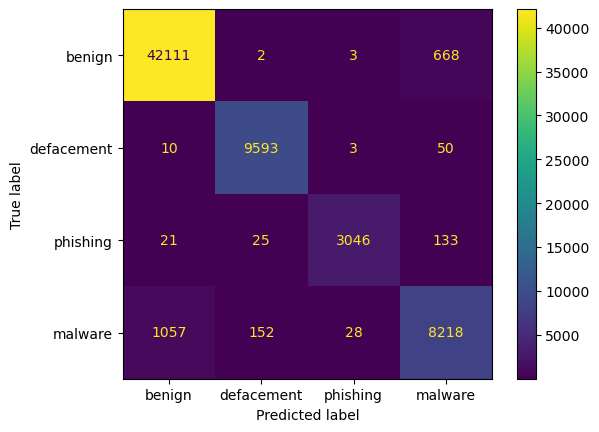

In [41]:
cm = confusion_matrix(y_test, rf_y_pred)
cx_ = ConfusionMatrixDisplay(cm,display_labels=['benign', 'defacement','phishing','malware']).plot()
plt.show()

In [42]:
import joblib

# saving model
rf_pkl = "rf.joblib"
with open(rf_pkl, 'wb') as f:
    joblib.dump(rf, f, compress=3)

In [43]:
with open('rf.joblib', 'rb') as f:
    loaded_rf = joblib.load(f)
    
rf_y_pred = loaded_rf.predict(X_test)
print(classification_report(y_test,rf_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     42784
           1       0.98      0.99      0.99      9656
           2       0.99      0.94      0.97      3225
           3       0.91      0.87      0.89      9455

    accuracy                           0.97     65120
   macro avg       0.96      0.95      0.96     65120
weighted avg       0.97      0.97      0.97     65120



## XGBoost

In [44]:
xgb = XGBClassifier(n_estimators= 100)
xgb.fit(X_train,y_train)
xgb_y_pred = xgb.predict(X_test)
print(classification_report(y_test, xgb_y_pred))


score = metrics.accuracy_score(y_test, xgb_y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42784
           1       0.97      0.99      0.98      9656
           2       0.97      0.92      0.94      3225
           3       0.91      0.84      0.87      9455

    accuracy                           0.96     65120
   macro avg       0.96      0.93      0.94     65120
weighted avg       0.96      0.96      0.96     65120

accuracy:   0.962


In [45]:
# saving model
xgb_pkl = "xgb.joblib"
with open(xgb_pkl, 'wb') as f:
    joblib.dump(xgb, f, compress=3)

In [46]:
with open('xgb.joblib', 'rb') as f:
    loaded_xgb = joblib.load(f)
    
xgb_y_pred = loaded_xgb.predict(X_test)
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42784
           1       0.97      0.99      0.98      9656
           2       0.97      0.92      0.94      3225
           3       0.91      0.84      0.87      9455

    accuracy                           0.96     65120
   macro avg       0.96      0.93      0.94     65120
weighted avg       0.96      0.96      0.96     65120



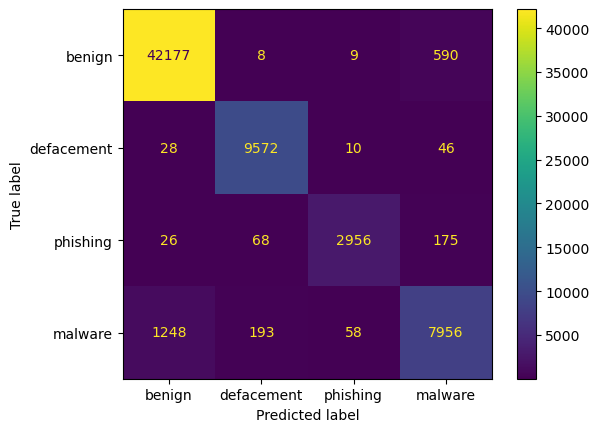

In [47]:
cm = confusion_matrix(y_test, xgb_y_pred)
cx_ = ConfusionMatrixDisplay(cm,display_labels=['benign', 'defacement','phishing','malware']).plot()
plt.show()